In [2]:
from google.colab import files
uploaded = files.upload()

Saving Statcast_2021.csv to Statcast_2021.csv


In [1]:
from google.colab import files
uploaded = files.upload()

Saving 2021pitch.csv to 2021pitch.csv


In [9]:
import pandas as pd

# 업로드된 파일 불러오기
kbo_df = pd.read_csv("2021pitch.csv", encoding='cp949')
mlb_df = pd.read_csv("Statcast_2021.csv")

# 컬럼명 추출
kbo_col_set = set(kbo_df.columns)
mlb_col_set = set(mlb_df.columns)

# 교집합 및 차집합 분석
column_intersection = kbo_col_set & mlb_col_set
only_kbo = kbo_col_set - mlb_col_set
only_mlb = mlb_col_set - kbo_col_set

# 결과 출력
print("✅ 공통 컬럼:", column_intersection)
print("✅ KBO 전용 컬럼:", only_kbo)
print("✅ MLB 전용 컬럼:", only_mlb)



✅ 공통 컬럼: {'Unnamed: 0'}
✅ KBO 전용 컬럼: {'세', '자책', '폭투', '고4', '타자', '완투', '이름', 'X2타', '정렬', '홀드', '출장', '이닝', '승', '비율.4', '비율', '비율.1', 'WAR', '볼넷', '보크', '완봉', '비율.2', '패', '홈런', 'WPA', 'X3타', '비율.3', '팀', '안타', '삼진', '선발', '실점', '사구'}
✅ MLB 전용 컬럼: {'inning', 'woba_value', 'pitch_name', 'strikes', 'hc_y', 'bb_type', 'launch_speed', 'pfx_z', 'break_length_deprecated', 'sz_bot', 'hit_location', 'home_score', 'zone', 'hc_x', 'post_bat_score', 'des', 'on_3b', 'fielder_5', 'player_name', 'release_speed', 'estimated_ba_using_speedangle', 'pitcher', 'batter', 'spin_dir', 'events', 'fielder_3', 'fld_score', 'sv_id', 'fielder_4', 'pitcher.1', 'iso_value', 'if_fielding_alignment', 'launch_speed_angle', 'description', 'az', 'delta_run_exp', 'plate_x', 'type', 'balls', 'inning_topbot', 'post_fld_score', 'launch_angle', 'tfs_zulu_deprecated', 'game_pk', 'outs_when_up', 'delta_home_win_exp', 'spin_axis', 'plate_z', 'bat_score', 'game_type', 'pitch_type', 'fielder_6', 'babip_value', 'release_pos_y'

In [12]:
# Step 1: Load Statcast data
mlb_df = pd.read_csv("Statcast_2021.csv")


# Step 2: Filter only rows where events are relevant (strikeout, walk, etc.)
relevant_events = mlb_df[mlb_df['events'].isin(['strikeout', 'walk'])]

# Step 3: Compute player-level MLB stats
mlb_stats = (
    relevant_events
    .groupby('player_name')
    .agg(
        strikeouts=('events', lambda x: (x == 'strikeout').sum()),
        walks=('events', lambda x: (x == 'walk').sum()),
        avg_speed=('release_speed', 'mean'),
        avg_spin_rate=('release_spin_rate', 'mean'),
        avg_plate_x=('plate_x', 'mean'),
        avg_plate_z=('plate_z', 'mean'),
        pitch_count=('events', 'count')  # total pitches to estimate innings
    )
    .reset_index()
)

# Step 4: Estimate innings pitched based on pitch count (very rough estimate)
# Assuming ~16 pitches per inning as a general average
mlb_stats['innings_pitched'] = mlb_stats['pitch_count'] / 16

# Step 5: Calculate BB/9 and K/BB
mlb_stats['BB9'] = mlb_stats['walks'] / mlb_stats['innings_pitched'] * 9
mlb_stats['KBB'] = mlb_stats['strikeouts'] / mlb_stats['walks'].replace(0, 1)  # avoid division by zero
mlb_stats['league'] = 'MLB'


print("MLB 요약 통계")
mlb_stats.head(10)



MLB 요약 통계


,player_name,strikeouts,walks,avg_speed,avg_spin_rate,avg_plate_x,avg_plate_z,pitch_count,innings_pitched,BB9,KBB,league
0,"Abad, Fernando",10,6,83.306250,2089.062500,-0.188125,1.705000,16,1.0000,54.000000,1.666667,MLB
1,"Abbott, Cory",11,11,89.390909,2291.181818,0.450909,2.205000,22,1.3750,72.000000,1.000000,MLB
2,"Abreu, Albert",35,18,92.594340,2120.094340,0.270943,1.870189,53,3.3125,48.905660,1.944444,MLB
3,"Abreu, Bryan",36,18,90.970370,2478.944444,0.351667,2.069074,54,3.3750,48.000000,2.000000,MLB
4,"Acevedo, Domingo",9,4,88.546154,2044.076923,0.192308,1.857692,13,0.8125,44.307692,2.250000,MLB
5,"Adam, Jason",18,6,87.862500,2595.333333,0.334167,2.211667,24,1.5000,36.000000,3.000000,MLB
6,"Adams, Austin",76,33,88.052294,2814.513761,0.484404,2.221560,109,6.8125,43.596330,2.303030,MLB
7,"Adon, Joan",9,3,89.541667,2184.916667,0.340000,1.447500,12,0.7500,36.000000,3.000000,MLB
8,"Aguilar, Miguel",3,3,86.816667,2194.666667,-0.646667,2.633333,6,0.3750,72.000000,1.000000,MLB
9,"Akin, Keegan",82,39,88.526446,2243.917355,-0.094050,2.302810,121,7.5625,46.413223,2.102564,MLB


In [15]:
import pandas as pd

# 1. 파일 로드
kbo_df = pd.read_csv("2021pitch.csv", encoding='cp949')
mlb_df = pd.read_csv("Statcast_2021.csv")

# 2. KBO 컬럼 매핑 딕셔너리
column_map = {
    '이름': 'player_name',
    '팀': 'home_team',
    '삼진': 'strikeouts',
    '볼넷': 'walks',
    '승': 'wins',
    '패': 'losses',
    '자책': 'earned_runs',
    '이닝': 'innings_pitched',
    'WAR': 'WAR',
    'WPA': 'WPA',
    '비율': 'ERA',
    '비율.1': 'BB9',
    '비율.2': 'KBB'
}

# 3. 컬럼명 표준화
kbo_df_renamed = kbo_df.rename(columns={k: v for k, v in column_map.items() if k in kbo_df.columns})

# 4. Statcast에서 삼진/볼넷 등 요약 집계
relevant_events = mlb_df[mlb_df['events'].isin(['strikeout', 'walk'])]

mlb_stats = (
    relevant_events
    .groupby('player_name')
    .agg(
        strikeouts=('events', lambda x: (x == 'strikeout').sum()),
        walks=('events', lambda x: (x == 'walk').sum()),
        avg_speed=('release_speed', 'mean'),
        avg_spin_rate=('release_spin_rate', 'mean'),
        avg_plate_x=('plate_x', 'mean'),
        avg_plate_z=('plate_z', 'mean'),
        pitch_count=('events', 'count')
    )
    .reset_index()
)

# 5. 추정 이닝 및 파생지표 생성
mlb_stats['innings_pitched'] = mlb_stats['pitch_count'] / 16
mlb_stats['BB9'] = mlb_stats['walks'] / mlb_stats['innings_pitched'] * 9
mlb_stats['KBB'] = mlb_stats['strikeouts'] / mlb_stats['walks'].replace(0, 1)
mlb_stats['league'] = 'MLB'

# 6. KBO에도 동일 컬럼 추가 (없으면 NaN으로 생성)
for col in ['avg_speed', 'avg_spin_rate', 'avg_plate_x', 'avg_plate_z']:
    if col not in kbo_df_renamed.columns:
        kbo_df_renamed[col] = None
kbo_df_renamed['league'] = 'KBO'

# 7. 공통 컬럼만 지정
common_cols = [
    'player_name', 'strikeouts', 'walks', 'innings_pitched',
    'BB9', 'KBB', 'avg_speed', 'avg_spin_rate', 'avg_plate_x', 'avg_plate_z', 'league'
]

# 8. 병합 및 저장
combined_df = pd.concat([
    kbo_df_renamed[common_cols],
    mlb_stats[common_cols]
], ignore_index=True)

combined_df.to_csv("combined_pitchers_stats_final.csv", index=False)
print("🟢 통합 완료: combined_pitchers_stats_final.csv")




🟢 통합 완료: combined_pitchers_stats_final.csv


<ipython-input-15-d7096ab39397>:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([


In [18]:


# 1. 전체 컬럼 이름 출력
print("📌 전체 컬럼 목록:")
print(df.columns.tolist())

# 2. 기본 정보 확인
print("\n📊 데이터프레임 정보:")
print(df.info())

# 3. 상위 5개 행 확인
print("\n🔍 상위 5개 샘플:")
print(df.head())




📌 전체 컬럼 목록:
['player_name', 'strikeouts', 'walks', 'innings_pitched', 'BB9', 'KBB', 'avg_speed', 'avg_spin_rate', 'avg_plate_x', 'avg_plate_z', 'league']

📊 데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181 entries, 0 to 1180
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   player_name      1181 non-null   object 
 1   strikeouts       1181 non-null   int64  
 2   walks            1181 non-null   int64  
 3   innings_pitched  1181 non-null   float64
 4   BB9              1181 non-null   float64
 5   KBB              1181 non-null   float64
 6   avg_speed        873 non-null    float64
 7   avg_spin_rate    873 non-null    float64
 8   avg_plate_x      873 non-null    float64
 9   avg_plate_z      873 non-null    float64
 10  league           1181 non-null   object 
dtypes: float64(7), int64(2), object(2)
memory usage: 101.6+ KB
None

🔍 상위 5개 샘플:
  player_name  strikeouts  walks  innings_pit

📊 [출력 1] 리그별 평균 및 표준편차
- KBO vs MLB 투수들의 성능 지표 평균 및 분산 정도를 확인합니다.

          BB9          KBB       strikeouts         walks         \
         mean    std  mean   std       mean    std   mean    std   
league                                                             
KBO      5.68   3.22  1.84  1.09      33.09  39.58  19.12  17.50   
MLB     45.48  25.35  2.67  1.78      48.15  49.39  17.29  15.26   

       innings_pitched         
                  mean    std  
league                         
KBO              40.87  44.15  
MLB               4.09   3.94  


📌 [출력 2] 클러스터 중심값
- 각 클러스터에 속한 투수들의 평균적 성향을 보여줍니다.

     BB9   KBB  strikeouts  walks  innings_pitched  cluster
0  37.14  3.23      111.70  36.94             9.29        0
1  66.46  1.40       15.90   9.97             1.62        1
2   4.40  1.44       76.42  39.39            92.05        2
3  18.76  2.98       24.20   9.45             8.66        3


📌 [출력 3] 클러스터별 리그 분포
- 특정 클러스터에 MLB or KBO가 몰려 있으면 성향 차이를 반영하는 증거입니다.

leagu

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53804 (\N{HANGUL SYLLABLE TU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/

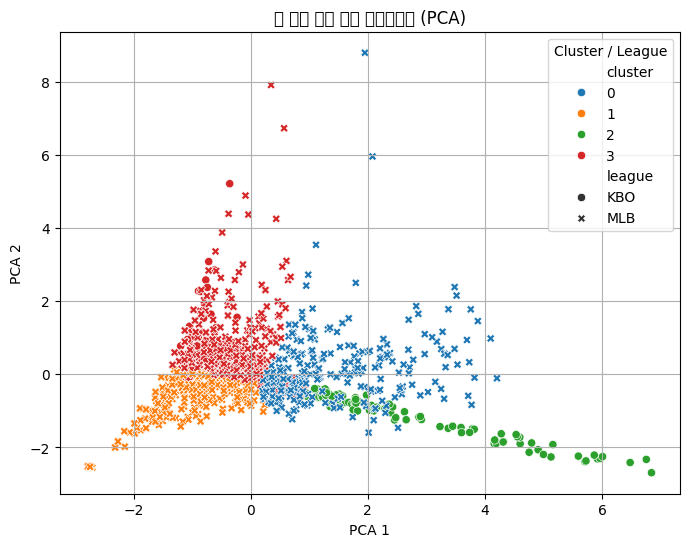

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53804 (\N{HANGUL SYLLABLE TU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

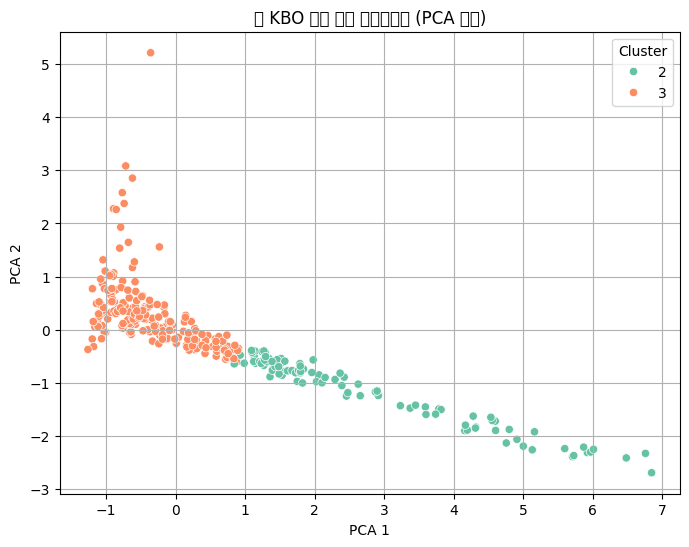

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53804 (\N{HANGUL SYLLABLE TU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

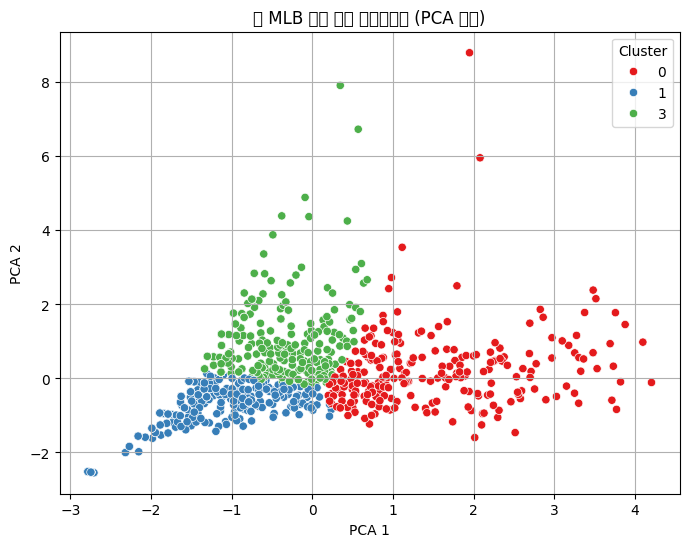

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/li

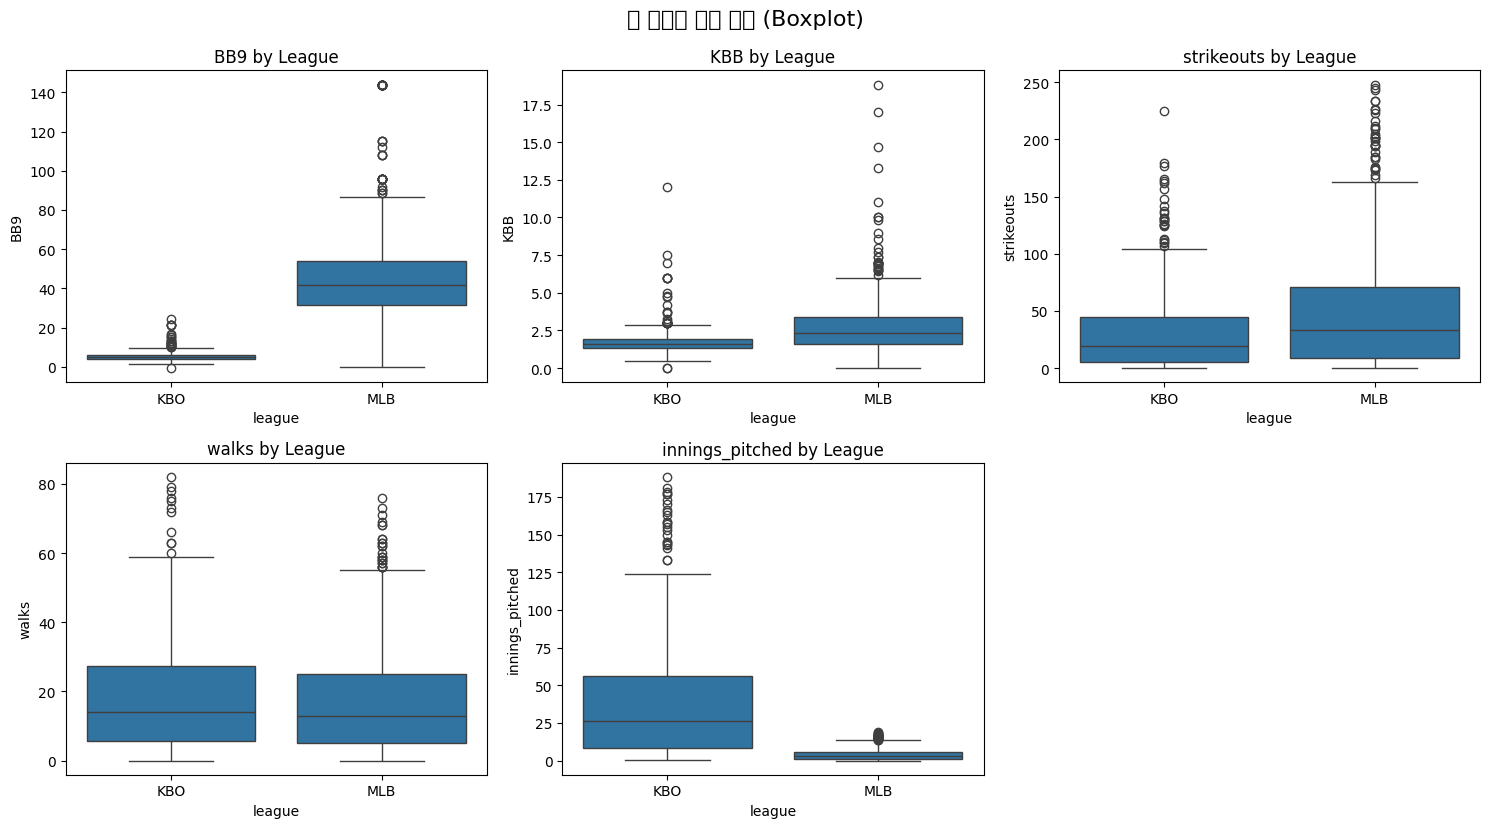

🧪 [출력 4] t-검정 결과 (KBO vs MLB)
- p < 0.05이면 두 리그 간 통계적으로 유의미한 차이가 있습니다.

- BB9             : t = -45.360, p =  0.0000 → ✅ 유의미한 차이 있음
- KBB             : t = -9.566, p =  0.0000 → ✅ 유의미한 차이 있음
- strikeouts      : t = -5.365, p =  0.0000 → ✅ 유의미한 차이 있음
- walks           : t =  1.633, p =  0.1031 → ❌ 통계적 차이 없음
- innings_pitched : t = 14.601, p =  0.0000 → ✅ 유의미한 차이 있음


In [24]:
# ✅ 패키지 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

# ✅ 1. 데이터 로딩
df = pd.read_csv("combined_pitchers_stats_final.csv")

# ✅ 2. 사용할 컬럼 정의 및 전처리
features = ["BB9", "KBB", "strikeouts", "walks", "innings_pitched"]
df = df[["player_name", "league"] + features].dropna()

# ✅ 3. 리그별 평균 및 표준편차
league_stats = df.groupby("league")[features].agg(["mean", "std"]).round(2)

print("="*60)
print("📊 [출력 1] 리그별 평균 및 표준편차")
print("- KBO vs MLB 투수들의 성능 지표 평균 및 분산 정도를 확인합니다.\n")
print(league_stats)
print("="*60 + "\n\n")

# ✅ 4. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# ✅ 5. KMeans 군집화
kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

# ✅ 6. 클러스터 중심값 (복원)
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features
).round(2)
cluster_centers["cluster"] = cluster_centers.index

print("📌 [출력 2] 클러스터 중심값")
print("- 각 클러스터에 속한 투수들의 평균적 성향을 보여줍니다.\n")
print(cluster_centers)
print("="*60 + "\n\n")

# ✅ 7. 클러스터별 리그 분포
cluster_counts = df.groupby(["cluster", "league"]).size().unstack(fill_value=0)

print("📌 [출력 3] 클러스터별 리그 분포")
print("- 특정 클러스터에 MLB or KBO가 몰려 있으면 성향 차이를 반영하는 증거입니다.\n")
print(cluster_counts)
print("="*60 + "\n\n")

# ✅ 8. PCA 차원 축소
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
df["pca1"], df["pca2"] = pca_components[:, 0], pca_components[:, 1]

# ✅ 8-1. 전체 PCA 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="cluster", style="league", palette="tab10")
plt.title("🎯 전체 투수 성향 클러스터링 (PCA)")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.grid(True)
plt.legend(title="Cluster / League")
plt.show()

# ✅ 8-2. KBO 전용 PCA 시각화
df_kbo = df[df["league"] == "KBO"]
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_kbo, x="pca1", y="pca2", hue="cluster", palette="Set2")
plt.title("🟢 KBO 투수 성향 클러스터링 (PCA 기준)")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

# ✅ 8-3. MLB 전용 PCA 시각화
df_mlb = df[df["league"] == "MLB"]
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_mlb, x="pca1", y="pca2", hue="cluster", palette="Set1")
plt.title("🔵 MLB 투수 성향 클러스터링 (PCA 기준)")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

# ✅ 9. 리그별 Boxplot
plt.figure(figsize=(15, 8))
for i, col in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=df, x="league", y=col)
    plt.title(f"{col} by League")
plt.tight_layout()
plt.suptitle("📦 리그별 성능 분포 (Boxplot)", fontsize=16, y=1.03)
plt.show()

# ✅ 10. t-검정
print("🧪 [출력 4] t-검정 결과 (KBO vs MLB)")
print("- p < 0.05이면 두 리그 간 통계적으로 유의미한 차이가 있습니다.\n")

for col in features:
    kbo = df[df["league"] == "KBO"][col]
    mlb = df[df["league"] == "MLB"][col]
    t, p = ttest_ind(kbo, mlb, equal_var=False)
    result = "→ ✅ 유의미한 차이 있음" if p < 0.05 else "→ ❌ 통계적 차이 없음"
    print(f"- {col:<16}: t = {t:6.3f}, p = {p:7.4f} {result}")



